This is the second home analysis.

In [206]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib.patches import Circle, Rectangle, Arc
from geopy.geocoders import Nominatim
from descartes import PolygonPatch
#import seaborn as sns
from pyproj import Proj, transform
import json
from shapely.geometry import mapping, shape
import statsmodels.api as sm  

import seaborn as sb  
sb.set_style('darkgrid')



In [216]:

def plot_polygon(ax, coordlist, edgecolor, color='white', alpha=0.5):

    
    # without Descartes, we could make a Patch of exterior
    
    poly = {"type": "Polygon", "coordinates": coordlist}
    ax.add_patch(PolygonPatch(poly, facecolor='white', edgecolor='black', linewidth=1.0, alpha=alpha))
    ax.plot(coordlist[:, 0],coordlist[:, 1], color='w')

def plot_multipolygon(ax, geom, color='red'):
    """ Can safely call with either Polygon or Multipolygon geometry
    change from original
    """
    if geom['type'] == 'Polygon':
        a = np.asarray(geom['coordinates'])
        plot_polygon(ax, a, color)
    elif geom['type'] == 'MultiPolygon':
         for g in geom['coordinates']:
            a = np.asarray(g)
            plot_polygon(ax, a, color)

#             plot_polygon(ax, poly, color)


Zillow Price of home for all cities

In [217]:
df = pd.read_csv('data/City_Zhvi_AllHomes.csv')

# cols_2_use = [  'RegionID',
#                  'RegionName',
#                  'State',
#                  'Metro',
#                  'CountyName',
#                  'SizeRank',
#                  '1996-04',
#                  '2001-03',
#                  '2006-03',
#                  '2011-03',
#                  '2016-03']

# df = df[cols_2_use]

Price to Rent Ratio for Zillow

In [218]:
df_price_2_rent = pd.read_csv('data/City_PriceToRentRatio_AllHomes.csv')

# cols_2_use = [  'RegionID',
#                 'RegionName',
#                 'State',
#                 '2011-03',
#                 '2016-03']

# df_price_2_rent = df_price_2_rent[cols_2_use]


### Existing climate for vacation rentals:
Area with vacation rentals? Analyze only cities that are in a county where more than 20% of the households are for recreational use.

In [219]:
## Vacation or not occupied

df['CountyState'] = df['CountyName'] + " County, " + df['State']

df_price_2_rent['CityState'] = df_price_2_rent['RegionName'] + ', ' + df_price_2_rent['State']

df['CityState'] = df['RegionName'] + ', ' + df['State']
new_df = pd.merge(df, df_price_2_rent, on='CityState', how='inner')
len(new_df)

11383

In [220]:
xl = pd.ExcelFile('data/seasonal_rates.csv')
df_seasonal = xl.parse('seasonal_rates.csv')
df_seasonal = df_seasonal[df_seasonal['seasonal use'] > 20.0]

df_seasonal['CountyState'] = df_seasonal['Geographic area'] + ', ' + df_seasonal['State Abbr']
new_df = pd.merge(new_df, df_seasonal, on='CountyState', how='inner')


seasonal_df = new_df

## Basis for proximity
If you are buying a vacation home, it is very much about proximity
Attached a latitude and longitude

In [221]:
# add geo location
df_geo = pd.read_csv('data/us_cities.csv')

# combine the city and state for merging
df_geo['CityState'] = df_geo['AccentCity'] + ', ' + df_geo['Region']
df_geo = pd.merge(seasonal_df, df_geo, on='CityState', how='inner')

#### Plot where the current locations are.

In [222]:
def add_us_outline(ax):
    with open('data/us_states.geojson') as data_file:    
        data = json.load(data_file)
        
    for feature in data['features']:
        plot_multipolygon(ax, feature['geometry'], color='black')
    
    #set the graph axes to the feature extents
    ax.set_xlim(-160.6708333, -65.9038889)
    ax.set_ylim(18.0638889, 50.0002778)


    

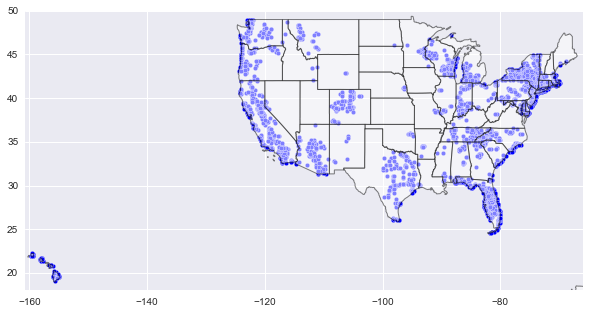

In [223]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_geo['Longitude'], df_geo['Latitude'], marker='o', edgecolor='w');


### Accessibility: 
Is it near a major airport? Find cities that are within at least 20 miles of major commercial airport.

In [224]:
# Load Airport Data
df_airports = pd.read_csv('data/us_airports.csv')

# remove non major airports
major_airports_codes = ["GA","LAX","ORD","DFW","JFK","DEN","SFO","CLT","LAS","PHX","IAH","MIA","SEA","EWR","MCO","MSP","DTW","BOS","PHL","LGA","FLL","BWI","IAD","MDW","SLC","DCA","HNL","SAN","TPA","PDX","STL","HOU","BNA","AUS","OAK","MCI","MSY","RDU","SJC","SNA","DAL","SMF","SJU","SAT","RSW","PIT","CLE","IND","MKE","CMH","OGG","PBI","BDL","CVG","JAX","ANC","BUF","ABQ","ONT","OMA","BUR"]

df_airports = df_airports[df_airports['code'].isin(major_airports_codes)]

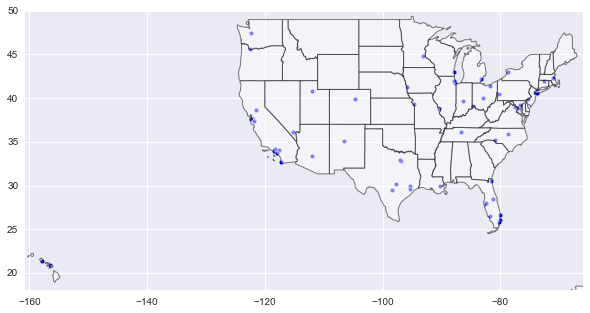

In [225]:
# Sanity Check
# make sure airports are in parts of the states that make sense
# validate that the data is correct (lat, lons for airports fall on the map)

fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_airports['lon'], df_airports['lat'], marker='o', edgecolor='w');

In [226]:
#converted units
cap = Proj('+datum=NAD83 +lat_0=32.10 +lat_1=33.53 '
    '+lat_2=32.47 +lon_0=-116.15 +no_defs +proj=lcc +units=us-ft '
    '+x_0=2000000 +y_0=500000', preserve_units=True)

wgs84 = Proj(init='epsg:4326')

def transform_lat_lon(row):
 
    try:
        x, y = transform(wgs84, cap, row['Longitude'], row['Latitude'])
        return x,y
    except:
        return np.nan 

def transform_lat_lon2(row):

    try:
        x, y = transform(wgs84, cap, row['lon'], row['lat'])
        return x,y
    except:
        return np.nan 
    
    
# gett city geo    
df_geo['x_feet'], df_geo['y_feet'] = zip(*df_geo.apply(transform_lat_lon, axis=1).tolist())

df_airports['x_feet'], df_airports['y_feet'] = zip(*df_airports.apply(transform_lat_lon2, axis=1).tolist())


In [227]:
import math
feet_to_mile = 5280.0
radius = 25

def check_location(row):
    center_x, center_y = row['x_feet'], row['y_feet']
    airport_close = False
    
    for index, airport in df_airports.iterrows():
        x, y = airport['x_feet'], airport['y_feet'] 
        eucl_dist = math.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) / feet_to_mile
        if eucl_dist < radius:
            airport_close = True
            break
    
    return airport_close


df_geo['near_airport'] = df_geo.apply(check_location, axis=1)    


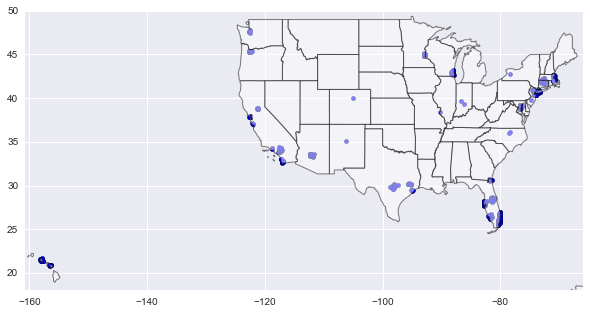

In [228]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
df_geo = df_geo[df_geo['near_airport'] == True]
ax.scatter(df_geo['Longitude'], df_geo['Latitude'], marker='o');


## Base Criteria
Going up in value, makes money renting, and cheap

### Investment: 
looking for upward trending growth in the value of the homes

In [229]:
df_geo['growth'] = (df_geo['2016-03_x'] - df_geo['2011-03_x']) / df_geo['2011-03_x']

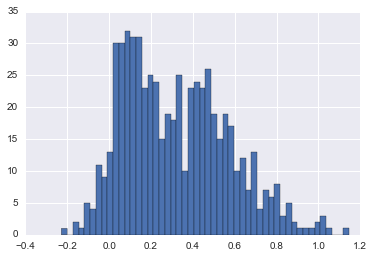

In [230]:
plt.hist(df_geo['growth'].dropna(), bins=50);


In [233]:


max_growth, min_growth = max(df_geo['growth']), min(df_geo['growth'])
difference = max_growth - min_growth

df_geo['growth_index'] = 100*(df_geo['growth'] - min_growth) / difference


### Revenue (Price to Rent)
The Price to Rent Ratio is the median ratio between a home's value and annualized rent.

It would be great to have this for the annual rate for investment

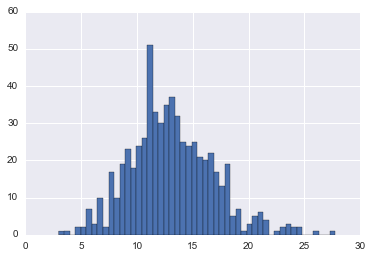

In [234]:
plt.hist(df_geo['2016-03_y'], bins=50);

In [235]:
max_revenue, min_revenue = max(df_geo['2016-03_y']), min(df_geo['2016-03_y'])
difference = max_revenue - min_revenue

df_geo['revenue_index'] = 100*(df_geo['2016-03_y'] - min_revenue) / difference


### Price
The lower the price the higher the index.

The median home value is $318500.0


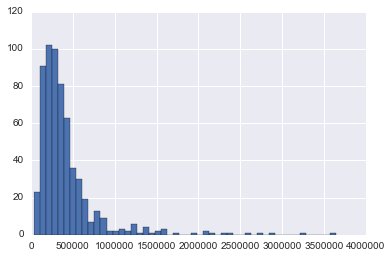

In [236]:
plt.hist(df_geo['2016-03_x'], bins=50);
print("The median home value is $" + str(df_geo['2016-03_x'].median()))

In [237]:
max_price, min_price = max(df_geo['2016-03_x']), min(df_geo['2016-03_x'])
difference = max_price - min_price
df_geo['price_index'] = 100*(max_price - df_geo['2016-03_x'] ) / difference


## Renters


the percentage of renters in the area.

In [238]:
min_seasonal, max_seasonal = min(df_geo['seasonal use']), max(df_geo['seasonal use'])
difference = max_seasonal - min_seasonal
df_geo['env_index'] = 100*(df_geo['seasonal use'] - min_seasonal) / difference


## Index
Create the value

In [239]:
df_geo['index'] = (.30 * df_geo['growth_index']) + (.30 * df_geo['revenue_index']) + (.30 * df_geo['price_index']) + (.10 * df_geo['env_index'])

cols_2_use = [  'AccentCity',
                'State_x',
                'index']

# sort descending from the highest index down and limit the top 10
df_out = df_geo.sort('index', ascending=False).head(10)

df_out[['RegionName_x', 'State_x', 'index']]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,RegionName_x,State_x,index
327,Lehigh Acres,FL,73.280070
612,Loomis,CA,71.728737
1767,Golden Gate,FL,71.496447
1964,Lahaina,HI,71.225661
176,Rubidoux,CA,70.350481
186,Glen Avon,CA,69.728618
138,El Portal,FL,69.499968
748,Boulder Creek,CA,68.898105
1771,Orangetree,FL,68.894262
13,El Mirage,AZ,68.856899


## Where are they located?


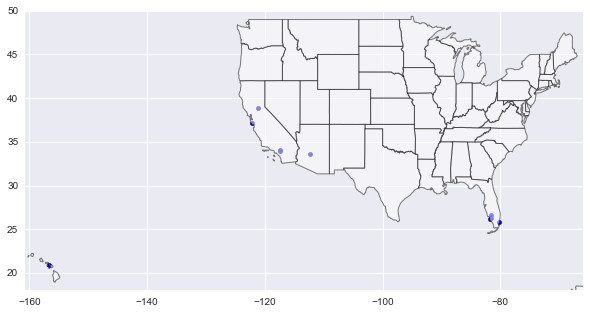

In [240]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_out['Longitude'], df_out['Latitude'], marker='o');

What if I try to develop a trend in the increase in home value?

In [241]:
# year_lst = [ str(j) + "-0" + str(k) if k < 10 else str(j) + "-" + str(k) for j in range(1997,2015)  for k in range(1,13)]
year_lst = ['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09', '1996-10', '1996-11', '1996-12', '1997-01', '1997-02', '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10_x','2010-11_x', '2010-12_x', '2011-01_x', '2011-02_x', '2011-03_x', '2011-04_x', '2011-05_x', '2011-06_x', '2011-07_x', '2011-08_x', '2011-09_x', '2011-10_x', '2011-11_x', '2011-12_x', '2012-01_x', '2012-02_x', '2012-03_x', '2012-04_x', '2012-05_x', '2012-06_x', '2012-07_x', '2012-08_x', '2012-09_x', '2012-10_x', '2012-11_x', '2012-12_x', '2013-01_x', '2013-02_x', '2013-03_x', '2013-04_x','2013-05_x', '2013-06_x', '2013-07_x', '2013-08_x', '2013-09_x', '2013-10_x', '2013-11_x', '2013-12_x', '2014-01_x', '2014-02_x', '2014-03_x', '2014-04_x', '2014-05_x', '2014-06_x', '2014-07_x', '2014-08_x', '2014-09_x', '2014-10_x', '2014-11_x', '2014-12_x', '2015-01_x', '2015-02_x', '2015-03_x', '2015-04_x', '2015-05_x', '2015-06_x', '2015-07_x', '2015-08_x', '2015-09_x', '2015-10_x', '2015-11_x', '2015-12_x', '2016-01_x', '2016-02_x', '2016-03_x']

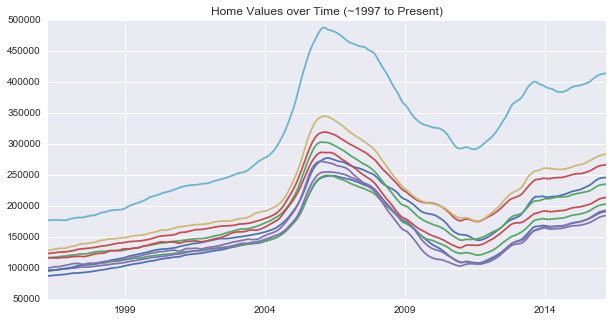

In [242]:

for index, row in df_geo.head(10).iterrows():
    
    start_month = int(year_lst[0].split("-")[1])
    start_year = int(year_lst[0].split("-")[0])
    date_range = pd.date_range(start=pd.datetime(start_year, start_month, 1), periods=len(year_lst), freq='M')
    over_time = pd.Series(row[year_lst].tolist(),index=date_range)
    
    over_time.plot(figsize=(10, 5), title="Home Values over Time (~1997 to Present)");
    



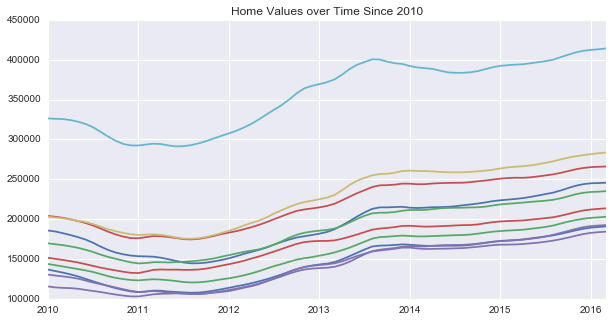

In [243]:


for index, row in df_geo.head(10).iterrows():
    
    start_month = int(year_lst[0].split("-")[1])
    start_year = int(year_lst[0].split("-")[0])
    date_range = pd.date_range(start=pd.datetime(start_year, start_month, 1), periods=len(year_lst), freq='M')
    over_time = pd.Series(row[year_lst].tolist(),index=date_range)

    recent_dates = over_time[over_time.index.year >= 2010]
    recent_dates.plot(figsize=(10, 5), title="Home Values over Time Since 2010");
    


    

In [244]:

from dateutil.relativedelta import relativedelta

for index, row in df_geo.head(1).iterrows():
    
    start_month = int(year_lst[0].split("-")[1])
    start_year = int(year_lst[0].split("-")[0])
    date_range = pd.date_range(start=pd.datetime(start_year, start_month, 1), periods=len(year_lst), freq='M')
    
    over_time = pd.Series(row[year_lst].tolist(),index=date_range)

    ts_log = np.log(over_time)
    model = sm.tsa.ARMA(over_time.dropna(), (1, 0)).fit(disp=-1)
    
    start = over_time.index[-1]
    date_range = pd.date_range(start=start, periods=12, freq='M')

    future = pd.Series(index=date_range)
    over_time = pd.concat([over_time, future])
#     print(over_time)

#     print(model.predict(start=date_range[0],end=date_range[-1], dynamic=True))


    





Above a certain population

## Near a coastline
